In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
df = pd.read_csv(r"C:\Users\zeyne\OneDrive\Desktop\merged_all_months.csv")

print("Satır sayısı:", df.shape[0])
df.head()


Satır sayısı: 2970692


,date,hour,route_code,stop_code,passenger_count,vehicle_type,district,is_outlier,is_peak_hour,day_of_week,is_weekend,mean_passenger_by_route_hour,month
0,2024-08-01,0,MESCIDI SELAM-ARNAVUTKOY-ISTANBUL HAVA LIMANI,OTOYOL,1,1,ATASEHIR,0,0,3,0,1.782609,bilinmeyen_ay
1,2024-08-01,0,MECIDIYEKOY-ISTANBUL HAVALIMANI,OTOYOL,1,1,ATASEHIR,0,0,3,0,1.200000,bilinmeyen_ay
2,2024-08-01,0,KOC UNV. RUMELIFENER KAMPUSU - TAKSIM,OTOYOL,3,1,ATASEHIR,0,0,3,0,1.666667,bilinmeyen_ay
3,2024-08-01,0,HACI OSMAN METRO - RUMELI FENERI,OTOYOL,1,1,ATASEHIR,0,0,3,0,1.538462,bilinmeyen_ay
4,2024-08-01,0,USKUDAR-GUZELTEPE-UMRANIYE DEVLET HASTANESI,OTOYOL,3,1,BAKIRKOY,0,0,3,0,4.258065,bilinmeyen_ay


Modelde kullanılacak sayısal (numeric) özellikleri tanımlıyoruz
Modelde kullanılacak kategorik (string/label) özellikleri tanımlıyoruz
Tahmin etmek istediğim hedef değişkeni (bağımlı değişken)
Bağımsız değişkenleri (özellikleri) dataframe'den seçiyoruz
Bağımlı değişkeni (hedef etiketi) dataframe'den alıyoruz

In [3]:
numeric_features = [
    "hour",
    "passenger_count",
    "vehicle_type",
    "is_outlier",
    "day_of_week",
    "is_weekend",
    "mean_passenger_by_route_hour"
]

categorical_features = [
    "route_code",
    "stop_code",
    "district"
]

target_col = "is_peak_hour"

X = df[numeric_features + categorical_features]
y = df[target_col]


Veriyi eğitim ve test olarak ayırıyoruz

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


Sayısal ve kategorik değişkenlere farklı ön işleme (preprocessing) adımları uygulamak için ColumnTransformer oluşturuyoruz


In [5]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


SVM modelini bir pipeline içine yerleştiriyoruz:
1) "prep": daha önce tanımlanan preprocessing (ölçekleme + OneHotEncoder)
2) "clf": SGDClassifier ile SVM (hinge loss) eğitimi
Modelin eğitildiğini belirtmek için çıktı yazdırıyoruz
SVM modelini eğitim verisi ile eğitiyoruz
Test verisi üzerinde tahmin yapıyoruz
Sonuçları ekrana yazdırıyoruz

In [6]:
svm_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3))
])

print("SVM modeli eğitiliyor...")
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)

print("\n SVM SONUÇLARI")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, svm_pred))


SVM modeli eğitiliyor...

 SVM SONUÇLARI
Accuracy: 0.5666165661570777
              precision    recall  f1-score   support

           0       0.57      0.52      0.54    293326
           1       0.57      0.61      0.59    300813

    accuracy                           0.57    594139
   macro avg       0.57      0.57      0.57    594139
weighted avg       0.57      0.57      0.57    594139

Confusion matrix:
 [[153425 139901]
 [117589 183224]]


Naive Bayes modelini bir pipeline içinde tanımlıyoruz:
1) "prep": preprocess → sayısal özellikleri ölçekler, kategorikleri OneHotEncoder ile dönüştürür
2) "clf": BernoulliNB → Bernoulli Naive Bayes sınıflandırıcısı
Modelin eğitim sürecinin başladığını yazdırıyoruz
Modeli eğitim verileriyle eğitiyoruz
Test verisi için tahmin yapıyoruz
Sonuçları ekrana yazdırıyoruz

In [7]:
nb_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", BernoulliNB())
])

print("Naive Bayes modeli eğitiliyor...")
nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

print("\nNAIVE BAYES SONUÇLARI (BernoulliNB)")
print("Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, nb_pred))


Naive Bayes modeli eğitiliyor...

NAIVE BAYES SONUÇLARI (BernoulliNB)
Accuracy: 0.5721960685967425
              precision    recall  f1-score   support

           0       0.57      0.57      0.57    293326
           1       0.58      0.58      0.58    300813

    accuracy                           0.57    594139
   macro avg       0.57      0.57      0.57    594139
weighted avg       0.57      0.57      0.57    594139

Confusion matrix:
 [[166993 126333]
 [127842 172971]]


SVM modelinin doğruluk skorunu ekrana yazdırıyoruz
Naive Bayes modelinin doğruluk skorunu ekrana yazdırıyoruz

In [8]:
print("\n MODEL KARŞILAŞTIRMASI ")
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))



 MODEL KARŞILAŞTIRMASI 
SVM Accuracy: 0.5666165661570777
Naive Bayes Accuracy: 0.5721960685967425


SVM modelinin performansını ekrana yazdırıyoruz
Doğruluk skoru ve Precision, recall, f1-score raporu
Naive Bayes modelinin performansını ekrana yazdırıyoruz
Doğruluk skoru ve Precision, recall, f1-score raporu

In [9]:
print("SVM ACC:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

print("NB ACC:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))


SVM ACC: 0.5666165661570777
              precision    recall  f1-score   support

           0       0.57      0.52      0.54    293326
           1       0.57      0.61      0.59    300813

    accuracy                           0.57    594139
   macro avg       0.57      0.57      0.57    594139
weighted avg       0.57      0.57      0.57    594139

NB ACC: 0.5721960685967425
              precision    recall  f1-score   support

           0       0.57      0.57      0.57    293326
           1       0.58      0.58      0.58    300813

    accuracy                           0.57    594139
   macro avg       0.57      0.57      0.57    594139
weighted avg       0.57      0.57      0.57    594139



Modelde kullanılacak numerik (ölçeklenmesi gereken) değişkenler burada tanımlanır.
Bu değişkenler StandardScaler ile normalize edilecektir.
Kategorik özelliklerin listesi
Bu değişkenler OneHotEncoder ile kategorik olarak dönüştürülecektir.



In [10]:
numeric_features = [
    "hour", "passenger_count", "vehicle_type",
    "is_outlier", "day_of_week", "is_weekend",
    "mean_passenger_by_route_hour"
]

categorical_features = [
    "route_code", "stop_code", "district"
]

target_col = "is_peak_hour"

X = df[numeric_features + categorical_features]
y = df[target_col]

# === TRAIN TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# === PREPROCESSER ===
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

Hyperparameter tuning için küçük bir örneklem seçiyoruz
Küçük örneklemi train ve validation olarak ikiye ayırıyoruz
Denenecek hiperparametre seçeneklerini tanımlıyoruz
MANUEL GRID SEARCH için: Modeli örnek train üzerinde eğit
                        Validation set üzerinde tahmin
                        Doğruluk hesaplama
                        En iyi parametreleri kaydet


In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sample_frac = 0.01   
sample_idx = X_train.sample(frac=sample_frac, random_state=42).index

X_train_sample = X_train.loc[sample_idx]
y_train_sample = y_train.loc[sample_idx]

print(f"Hyperparameter tuning için kullanılan örneklem: {X_train_sample.shape[0]} satır")


X_s_train, X_s_val, y_s_train, y_s_val = train_test_split(
    X_train_sample, y_train_sample,
    test_size=0.2,
    random_state=42,
    stratify=y_train_sample
)

loss_options = ["hinge", "log_loss"]
alpha_options = [0.0001, 0.001, 0.01]
max_iter_options = [1000]

best_score = 0
best_params = None

print("\nHyperparameter tuning başlıyor...\n")

for loss in loss_options:
    for alpha in alpha_options:
        for max_iter in max_iter_options:
            model = Pipeline(steps=[
                ("prep", preprocess),
                ("clf", SGDClassifier(
                    loss=loss,
                    alpha=alpha,
                    max_iter=max_iter,
                    tol=1e-3,
                    random_state=42
                ))
            ])

            # Sadece küçük sample train üzerinde eğit
            model.fit(X_s_train, y_s_train)

            # Validation sample üzerinde skor
            y_val_pred = model.predict(X_s_val)
            score = accuracy_score(y_s_val, y_val_pred)

            print(f"loss={loss}, alpha={alpha}, max_iter={max_iter} --> val acc={score:.4f}")

            if score > best_score:
                best_score = score
                best_params = {
                    "loss": loss,
                    "alpha": alpha,
                    "max_iter": max_iter
                }

print("\nEn iyi parametreler:", best_params)
print("Validation accuracy (best):", best_score)


Hyperparameter tuning için kullanılan örneklem: 23766 satır

Hyperparameter tuning başlıyor...

loss=hinge, alpha=0.0001, max_iter=1000 --> val acc=0.5429
loss=hinge, alpha=0.001, max_iter=1000 --> val acc=0.5482
loss=hinge, alpha=0.01, max_iter=1000 --> val acc=0.5524
loss=log_loss, alpha=0.0001, max_iter=1000 --> val acc=0.5465
loss=log_loss, alpha=0.001, max_iter=1000 --> val acc=0.5526
loss=log_loss, alpha=0.01, max_iter=1000 --> val acc=0.5374

En iyi parametreler: {'loss': 'log_loss', 'alpha': 0.001, 'max_iter': 1000}
Validation accuracy (best): 0.5525872949095498


En iyi parametrelerle tüm train verisinde modeli tekrar eğitiyoruz
Test set üzerinde tahmin ediyoruz

In [12]:
# En iyi parametrelerle tüm train verisinde modeli tekrar eğitiyoruz
best_svm = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SGDClassifier(
        loss=best_params["loss"],
        alpha=best_params["alpha"],
        max_iter=best_params["max_iter"],
        tol=1e-3,
        random_state=42
    ))
])

print("\nEn iyi parametrelerle SVM modeli eğitiliyor (tüm train set)...")
best_svm.fit(X_train, y_train)

# Test set üzerinde tahmin
svm_pred = best_svm.predict(X_test)

print("\n=== SVM (Tuned) Test Sonuçları ===")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))



En iyi parametrelerle SVM modeli eğitiliyor (tüm train set)...

=== SVM (Tuned) Test Sonuçları ===
Accuracy: 0.558751403291149
              precision    recall  f1-score   support

           0       0.56      0.49      0.52    293326
           1       0.56      0.63      0.59    300813

    accuracy                           0.56    594139
   macro avg       0.56      0.56      0.56    594139
weighted avg       0.56      0.56      0.56    594139



SVM Confusion Matrix

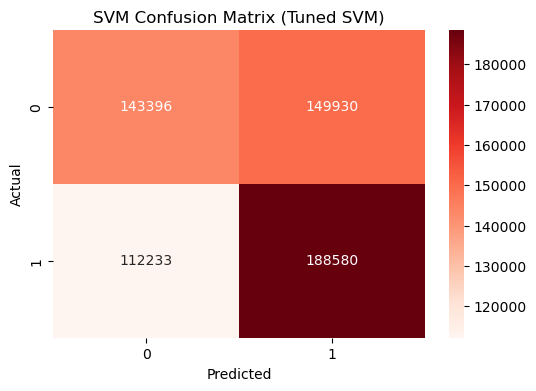

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_svm = confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Reds")
plt.title("SVM Confusion Matrix (Tuned SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


SVM Modeli - Confusion Matrix (Karmaşıklık Matrisi)

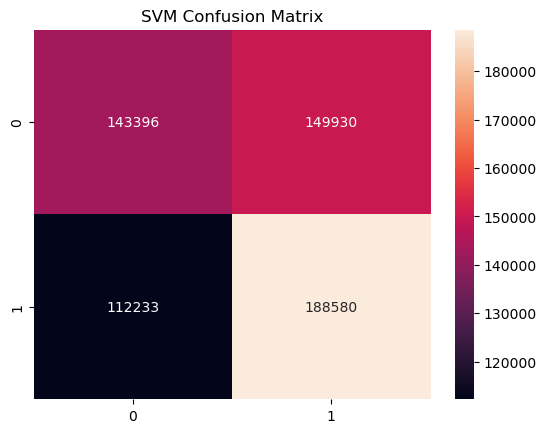

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("SVM Confusion Matrix")
plt.show()


Her iki model için de Model tahminlerinin sınıf dağılımı

C:\Users\zeyne\AppData\Local\Temp\ipykernel_1516\1880923734.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=svm_pred, palette="cool")
C:\Users\zeyne\AppData\Local\Temp\ipykernel_1516\1880923734.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=nb_pred, palette="coolwarm")


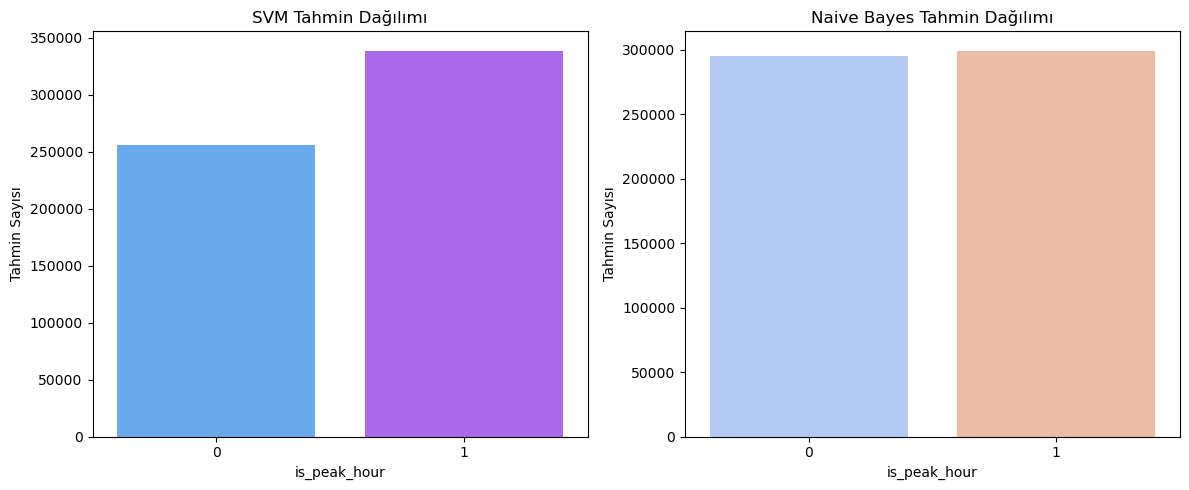

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x=svm_pred, palette="cool")
plt.title("SVM Tahmin Dağılımı")
plt.xlabel("is_peak_hour")
plt.ylabel("Tahmin Sayısı")

plt.subplot(1,2,2)
sns.countplot(x=nb_pred, palette="coolwarm")
plt.title("Naive Bayes Tahmin Dağılımı")
plt.xlabel("is_peak_hour")
plt.ylabel("Tahmin Sayısı")

plt.tight_layout()
plt.show()


Model tahminleri vs gerçek değerlerin dağılımı

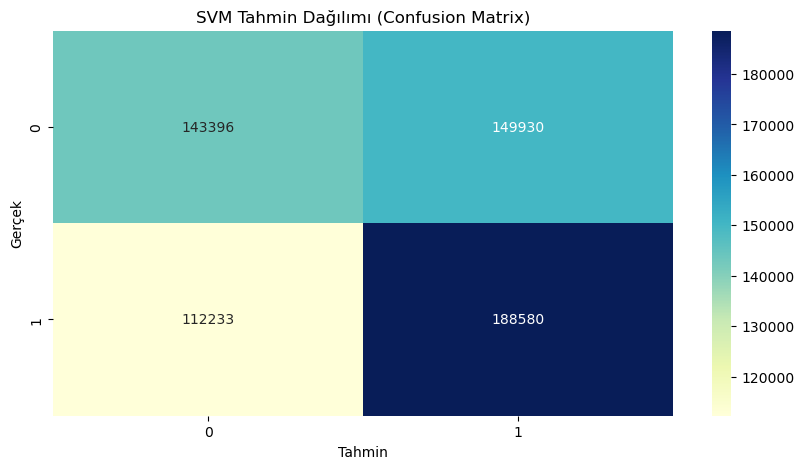

In [16]:
plt.figure(figsize=(10,5))
cm_svm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="YlGnBu")
plt.title("SVM Tahmin Dağılımı (Confusion Matrix)")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()
